### Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

import time     
import os
from radon.metrics import mi_visit
from radon.complexity import cc_visit

In [9]:
# for checking if cuda is working c:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Dataset (preprocessing)

In [10]:
df = pd.read_csv('Dataset\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [11]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [12]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [13]:
unique_values = df[' Label'].unique()
print(unique_values)

['BENIGN' 'DDoS']


In [14]:
df.columns = df.columns.str.strip() # pang tanggal ng space kasi may space sa column names hehe

In [15]:
df.columns # yey wala na space sa harap

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [16]:
df['Label'] = df['Label'].apply(lambda x: 1 if 'DDoS' in x else 0)

In [17]:
check_Label = df['Label'].unique()
print(check_Label) # 0 = Benign, 1 = DDoS

[0 1]


In [18]:
df = df.replace([float('inf'), float('-inf')], pd.NA).dropna() # dropping rows with nan and inf values

### Standardize and Splitting

In [19]:
X = df.drop(columns=['Label'])
y = df['Label']

In [20]:
X

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [21]:
y

0         0
1         0
2         0
3         0
4         0
         ..
225740    0
225741    0
225742    0
225743    0
225744    0
Name: Label, Length: 225711, dtype: int64

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # standardize features

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
df['Label'].value_counts() # 0 = Benign, 1 = DDoS

Label
1    128025
0     97686
Name: count, dtype: int64

### Creating dataset and loaders

In [25]:
# convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [26]:
# create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [27]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Model (LSTM + Vanilla Autoencoder)

In [28]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super().__init__()

        # More powerful encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.SiLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # More powerful decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.SiLU(),
            nn.Linear(512, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Clamp mu and logvar to avoid extreme values
        mu = torch.clamp(mu, min=-10, max=10)
        logvar = torch.clamp(logvar, min=-10, max=10)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar, z

In [29]:
def vae_loss(x, x_reconstructed, mu, logvar):
    # Reconstruction loss (MSE)
    reconstruction_loss = F.mse_loss(x_reconstructed, x, reduction='mean')

    # KL divergence between the learned latent distribution and a unit Gaussian
    kl_divergence = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + kl_divergence

In [30]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_dim=64):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [31]:
# model initialization
input_dim = X_train.shape[1]
latent_dim = 32

autoencoder = VAE(input_dim, latent_dim).to(device)
lstm = LSTMClassifier(input_size=latent_dim).to(device)

ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)
lstm_optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss instead of BCE with manual sigmoid

In [32]:
# start training time
train_start = time.time()

# hyperparameters
num_epochs = 50
patience = 5
save_path = 'BEST_LSTM_VariationalAE_MODEL.pth'

# early stopping variables
best_acc = 0
epochs_no_improve = 0

# metric storage
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_f1s, test_f1s = [], []

for epoch in range(num_epochs):
    autoencoder.train()
    lstm.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1).float()

        ae_optimizer.zero_grad()
        lstm_optimizer.zero_grad()

        # Forward pass through autoencoder
        x_reconstructed, mu, logvar, z = autoencoder(X_batch)
        z_seq = z.unsqueeze(1)

        # Forward pass through LSTM
        y_pred = lstm(z_seq)

        # VAE loss
        reconstruction_kl_loss = vae_loss(X_batch, x_reconstructed, mu, logvar)

        # Apply BCE loss with logits (no need to apply sigmoid manually)
        loss = reconstruction_kl_loss + criterion(y_pred, y_batch)
        loss.backward()

        # Step for both optimizers
        ae_optimizer.step()
        lstm_optimizer.step()

        total_loss += loss.item()
        predicted = (y_pred > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct / total * 100
    train_f1 = f1_score(all_labels, all_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    train_f1s.append(train_f1)

    # eval on test set
    autoencoder.eval()
    lstm.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1).float()

            # Forward pass through autoencoder
            x_reconstructed, mu, logvar, z = autoencoder(X_batch)
            z_seq = z.unsqueeze(1)

            # Forward pass through LSTM
            y_pred = lstm(z_seq)

            # VAE loss
            reconstruction_kl_loss = vae_loss(X_batch, x_reconstructed, mu, logvar)

            # Apply BCE loss with logits (no need to apply sigmoid manually)
            test_loss += reconstruction_kl_loss + criterion(y_pred, y_batch)

            predicted = (y_pred > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_acc = correct / total * 100
    test_f1 = f1_score(all_labels, all_preds)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
    test_f1s.append(test_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train -> Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.2f}%, F1: {train_f1:.4f}")
    print(f"  Test  -> Loss: {avg_test_loss:.4f}, Accuracy: {test_acc:.2f}%, F1: {test_f1:.4f}")

    # Early stopping and model checkpoint
    if test_acc > best_acc:
        best_acc = test_acc
        epochs_no_improve = 0
        torch.save({
            'autoencoder_state_dict': autoencoder.state_dict(),
            'lstm_state_dict': lstm.state_dict(),
            'ae_optimizer_state_dict': ae_optimizer.state_dict(),
            'lstm_optimizer_state_dict': lstm_optimizer.state_dict(),
            'epoch': epoch,
            'best_acc': best_acc
        }, save_path)
        print(f"Model saved at epoch {epoch+1} with accuracy: {best_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

    # Gradient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), max_norm=1.0)

# end training time
train_end = time.time()
training_time = train_end - train_start

# estimate inference time
inference_start = time.time()
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        _, _, _, z = autoencoder(X_batch)  # FIXED
        z_seq = z.unsqueeze(1)
        _ = lstm(z_seq)
inference_end = time.time()
inference_time = inference_end - inference_start

Epoch [1/50]
  Train -> Loss: 0.8693, Accuracy: 92.51%, F1: 0.9302
  Test  -> Loss: 0.5349, Accuracy: 98.70%, F1: 0.9885
Model saved at epoch 1 with accuracy: 98.70%
Epoch [2/50]
  Train -> Loss: 0.5306, Accuracy: 98.63%, F1: 0.9879
  Test  -> Loss: 0.4351, Accuracy: 98.67%, F1: 0.9882
No improvement for 1 epoch(s).
Epoch [3/50]
  Train -> Loss: 0.4685, Accuracy: 98.89%, F1: 0.9902
  Test  -> Loss: 0.4084, Accuracy: 99.05%, F1: 0.9916
Model saved at epoch 3 with accuracy: 99.05%
Epoch [4/50]
  Train -> Loss: 0.4073, Accuracy: 99.20%, F1: 0.9929
  Test  -> Loss: 0.3239, Accuracy: 99.49%, F1: 0.9955
Model saved at epoch 4 with accuracy: 99.49%
Epoch [5/50]
  Train -> Loss: 0.3435, Accuracy: 99.45%, F1: 0.9952
  Test  -> Loss: 0.2860, Accuracy: 99.64%, F1: 0.9968
Model saved at epoch 5 with accuracy: 99.64%
Epoch [6/50]
  Train -> Loss: 0.3072, Accuracy: 99.64%, F1: 0.9969
  Test  -> Loss: 0.2557, Accuracy: 99.62%, F1: 0.9967
No improvement for 1 epoch(s).
Epoch [7/50]
  Train -> Loss: 0.

In [37]:
# model file size
model_size_kb = os.path.getsize(save_path) / 1024 if os.path.exists(save_path) else 0.0
misclassification_rate = 100 - best_acc

# maintainability index
with open('LSTM_VariationalAE_Model.py', 'r') as f:
    code = f.read()
blocks = cc_visit(code)
mi_score = mi_visit(code, blocks)

print("\n=== Summary ===")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Storage Consumption: {model_size_kb:.2f} KB")
print(f"Misclassification Rate: {misclassification_rate:.2f}")
print(f"Inference Time: {inference_time:.4f} seconds")
print(f"Maintainability Index: {mi_score:.2f}")


=== Summary ===
Training Time: 565.78 seconds
Storage Consumption: 5267.64 KB
Misclassification Rate: 0.14
Inference Time: 1.7861 seconds
Maintainability Index: 53.10


### Plots and Results

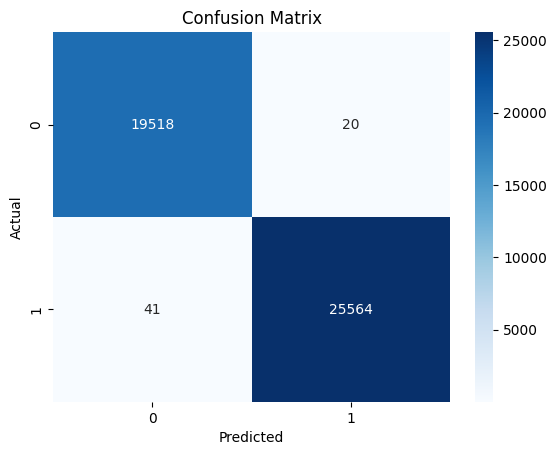

In [34]:
# confusion matrix and roc curve
autoencoder.eval()
lstm.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        x_reconstructed, mu, logvar, z = autoencoder(X_batch)
        z_seq = z.unsqueeze(1)
        y_pred = lstm(z_seq)

        probs = y_pred.cpu().numpy()
        preds = (y_pred > 0.5).float().cpu().numpy()
        labels = y_batch.cpu().numpy()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels)

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

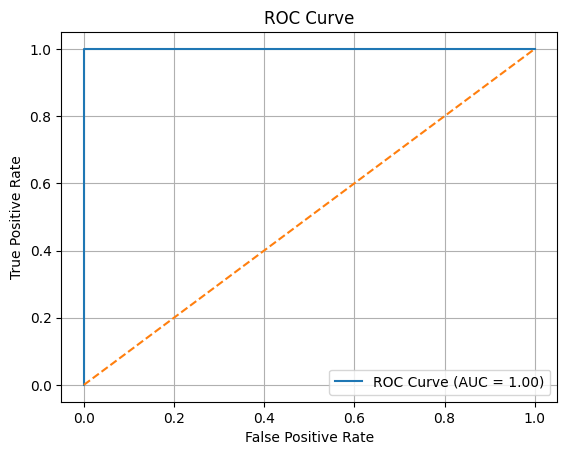

In [35]:
# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
autoencoder.eval()
lstm.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)

        x_reconstructed, mu, logvar, z = autoencoder(X_batch)
        z_seq = z.unsqueeze(1)
        y_pred = lstm(z_seq)

        predicted = (y_pred > 0.5).float()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Generate classification report
print("\n Classification Report")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'DdoS']))


 Classification Report
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     19538
        DdoS       1.00      1.00      1.00     25605

    accuracy                           1.00     45143
   macro avg       1.00      1.00      1.00     45143
weighted avg       1.00      1.00      1.00     45143

